# Tracking speed - Benchmarks

In this experiment, we evaluate the tracking performance of:

* MLflow - https://mlflow.org/
* WandB - https://wandb.ai/
* Neptune - https://neptune.ai/
* Aim - https://aimstack.io/
* Comet - https://www.comet.com/
* MLtraq - https://mltraq.com/

Varying:

* Number of experiments tracked
* Number of runs tracked
* Number of values tracked

Configuration:
* Tracking is limited to `int` values, disabling everything else such as git, code, environment and system stats
* Experiments running offline, logging disabled, storage on local filesystem
* Every experiment starts with an empty directory for storage
* Results averaged on `10` runs


## Imports and utility functions

In [1]:
%load_ext pyinstrument

In [2]:
import logging
import shutil
import threading
import uuid
from contextlib import contextmanager, redirect_stderr, redirect_stdout
from os import devnull, environ, makedirs, remove

import aim
import comet_ml
import matplotlib.pyplot as plt
import mlflow
import mltraq
import neptune
import wandb
from mltraq.utils.plot import bar_plot

In [3]:
# Versions

print("mlflow", mlflow.__version__)
print("neptune", neptune.__version__)
print("wandb", wandb.__version__)
print("aim", aim.__version__.__version__)
print("comet", comet_ml.__version__)
print("mltraq", mltraq.__version__)

mlflow 2.10.2
neptune 1.9.1
wandb 0.16.3
aim 3.18.1
comet 3.38.0
mltraq 0.0.117


In [28]:
# Utility functions


@contextmanager
def suppress_stdout_stderr():
    """
    A context manager that redirects stdout and stderr to devnull.
    """
    with open(devnull, "w") as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)


def remove_file(pathname):
    """
    Remove file `pathname` if existing.
    """
    try:
        remove(pathname)
    except OSError:
        pass


def create_dir(pathdir):
    """
    Create `pathdir`, recursively. If already existing, do nothing.
    """
    makedirs(pathdir, exist_ok=True)


def pct_change(v0, v1):
    """
    Return percentage change from v0 to v1.
    """
    return (v1 - v0) / v0 * 100

## Test procedure for WandB

In [39]:
def test_wandb(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Weights & Biases tracking with a specified number of experiments, runs and values.
    """

    # Required to: silence ipython output, disable sentry tracking.
    # This needs to be inside the test function to propagate to child processes.
    environ["WANDB_SILENT"] = "true"
    environ["WANDB_ERROR_REPORTING"] = "false"
    environ["WANDB_DISABLE_GIT"] = "true"
    environ["DISABLE_CODE"] = "true"

    tmp_dir = f"tmp/{uuid.uuid4()}"
    create_dir(f"{tmp_dir}/wandb")
    for _ in range(n_experiments):
        experiment_id = str(uuid.uuid4())
        for _ in range(n_runs):
            run_id = str(uuid.uuid4())
            wandb.init(project=experiment_id, group=run_id, dir=tmp_dir, mode="offline")
            for _ in range(n_values):
                wandb.log({"value": 12345})
    wandb.finish()

In [40]:
%%pyinstrument
test_wandb(n_experiments=1, n_runs=1, n_values=1)


_     ._   __/__   _ _  _  _ _/_   Recorded: 15:05:36  Samples:  52
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.546     CPU time: 0.056
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-bb001807-fdec-4423-92b1-b0172d85a19b.json

1.546 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_56659/3415908579.py:1
`- 1.546 test_wandb  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_56659/3159492715.py:1
   |- 1.490 finish  wandb/sdk/wandb_run.py:4108
   |     [28 frames hidden]  wandb, threading, <built-in>, sentry_sdk
   |        1.001 lock.acquire  <built-in>
   |        0.463 lock.acquire  <built-in>
   `- 0.055 init  wandb/sdk/wandb_init.py:940
         [3 frames hidden]  wandb

## Test procedure for MLflow

In [41]:
def test_mlflow(n_experiments=1, n_runs=1, n_values=1):
    """
    Test MLflow tracking with a specified number of experiments, runs and values.
    """

    create_dir("tmp")
    db_fname = f"tmp/{uuid.uuid4()}.db"
    mlflow.set_tracking_uri(f"sqlite:///{db_fname}")
    for _ in range(n_experiments):
        experiment_id = mlflow.create_experiment(str(uuid.uuid4()))
        for _ in range(n_runs):
            with mlflow.start_run(experiment_id=experiment_id):
                for _ in range(0, n_values):
                    mlflow.log_metric(key="value", value=12345)
            mlflow.end_run()
    remove_file(db_fname)

In [42]:
%%pyinstrument
test_mlflow()


_     ._   __/__   _ _  _  _ _/_   Recorded: 15:05:41  Samples:  179
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.752     CPU time: 0.460
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-bb001807-fdec-4423-92b1-b0172d85a19b.json

1.751 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_56659/2371405818.py:1
`- 1.751 test_mlflow  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_56659/4292842259.py:1
   |- 1.533 ActiveRun.__exit__  mlflow/tracking/fluent.py:191
   |     [17 frames hidden]  mlflow, comet_ml, threading, <built-in>
   |        1.192 lock.acquire  <built-in>
   |- 0.154 create_experiment  mlflow/tracking/fluent.py:1532
   |     [20 frames hidden]  mlflow, alembic, <string>
   `- 0.063 wrapper  comet_ml/monkey_patching.py:261
         [10 frames hidden]  comet_ml, <built-in>

## Test procedure for Neptune

In [67]:
def test_neptune(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Neptune tracking with a specified number of experiments, runs and values.
    """

    for _ in range(n_experiments):
        # No "experiment" concept in Neptune, and we cannot create "projects" offline on the free plan.
        # Also, not easy to set a custom directory, it will log things in .neptune/
        for _ in range(n_runs):
            run = neptune.init_run(project=f"workspace/{str(uuid.uuid4())}", mode="offline", git_ref=False)
            for _ in range(0, n_values):
                run["value"].append(12345)
            run.wait()
            run.stop()

In [68]:
%%pyinstrument
test_neptune()

_     ._   __/__   _ _  _  _ _/_   Recorded: 15:40:05  Samples:  9
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.011     CPU time: 0.012
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-bb001807-fdec-4423-92b1-b0172d85a19b.json

0.010 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_56659/3214493869.py:1
`- 0.010 test_neptune  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_56659/3034418967.py:1
   |- 0.008 Run.__init__  neptune/metadata_containers/run.py:307
   |     [53 frames hidden]  neptune, pathlib, <built-in>, <frozen...
   |- 0.001 Run.wait  neptune/metadata_containers/metadata_container.py:585
   |     [4 frames hidden]  neptune
   `- 0.001 Run.stop  neptune/metadata_containers/metadata_container.py:410
         [6 frames hidden]  neptune, pathlib

## Test procedure for Aim

In [11]:
def test_aim(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Aim tracking with a specified number of experiments, runs and values.
    """

    create_dir("tmp/aim/")
    repo = f"tmp/aim/{uuid.uuid4()}"
    for _ in range(n_experiments):
        for _ in range(n_runs):
            run_id = str(uuid.uuid4())
            # Doc: https://aimstack.readthedocs.io/en/latest/refs/sdk.html#aim.sdk.run.Run
            # Experiments in Aim match to what we call runs in this notebook.
            run = aim.Run(repo=repo, experiment=run_id, system_tracking_interval=None, capture_terminal_logs=False)
            for _ in range(0, n_values):
                run.track({"value": 12345})

In [12]:
%%pyinstrument
test_aim()

_     ._   __/__   _ _  _  _ _/_   Recorded: 14:54:13  Samples:  44
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.844     CPU time: 0.065
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-bb001807-fdec-4423-92b1-b0172d85a19b.json

0.843 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_56659/3340399674.py:1
|- 0.749 test_aim  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_56659/1354955865.py:1
|  `- 0.749 wrapper  aim/ext/exception_resistant.py:65
|        [42 frames hidden]  aim, subprocess, <built-in>, sqlalchemy
|           0.405 waitpid  <built-in>
|           0.169 Repo._get_container  aim/sdk/repo.py:268
`- 0.094 finalize.__call__  weakref.py:585
      [2 frames hidden]  weakref

## Test procedure for Comet

In [70]:
def test_comet(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Comet tracking with a specified number of experiments, runs and values.
    """

    tmp_dir = f"tmp/comet/{uuid.uuid4()}"
    create_dir(tmp_dir)
    for _ in range(n_experiments):
        experiment_id = str(uuid.uuid4())
        for _ in range(n_runs):
            run_id = str(uuid.uuid4().hex)  # Only alphanum IDs for Comet experiments, which match our semantics of runs
            run = comet_ml.OfflineExperiment(
                project_name=experiment_id,
                log_code=False,
                log_graph=False,
                log_env_gpu=False,
                log_env_cpu=False,
                log_env_network=False,
                log_env_disk=False,
                log_env_host=False,
                log_git_metadata=False,
                offline_directory=tmp_dir,
                experiment_key=run_id,
                display_summary_level=0,
            )
            for _ in range(0, n_values):
                run.log_metrics({"value": 12345})
            run.end()

In [71]:
%%pyinstrument
test_comet()

_     ._   __/__   _ _  _  _ _/_   Recorded: 15:44:45  Samples:  18
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.079     CPU time: 0.025
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-bb001807-fdec-4423-92b1-b0172d85a19b.json

0.077 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_56659/3382937944.py:1
`- 0.077 test_comet  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_56659/3943126899.py:1
   |- 0.062 OfflineExperiment.end  comet_ml/experiment.py:686
   |     [34 frames hidden]  comet_ml, <built-in>, zipfile, json, ...
   |        0.055 sleep  <built-in>
   |- 0.014 OfflineExperiment.__init__  comet_ml/offline.py:231
   |     [45 frames hidden]  comet_ml, <built-in>, threading, pkg_...
   `- 0.001 create_dir  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_56659/744156954.py:24
      `- 0.001 makedirs  <frozen os>:200
            [3 frames hidden]  <frozen os>, <built-in>

## Test procedure for MLtraq

In [47]:
def test_mltraq(n_experiments=1, n_runs=1, n_values=1):
    """
    Test MLtraq tracking with a specified number of experiments, runs and values.
    """

    create_dir("tmp")
    db_fname = f"tmp/{uuid.uuid4()}.db"
    session = mltraq.create_session(f"sqlite:///{db_fname}")
    with mltraq.options.ctx({"tqdm.disable": True}):
        for _ in range(n_experiments):
            experiment = session.create_experiment()
            for _ in range(n_runs):
                with experiment.run() as run:
                    run.fields.value = []
                    for _ in range(0, n_values):
                        run.fields.value.append(12345)
            experiment.persist()
    remove_file(db_fname)

In [48]:
%%pyinstrument
test_mltraq()

_     ._   __/__   _ _  _  _ _/_   Recorded: 15:16:40  Samples:  27
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.029     CPU time: 0.031
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-bb001807-fdec-4423-92b1-b0172d85a19b.json

0.028 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_56659/2389778167.py:1
`- 0.028 test_mltraq  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_56659/4002146439.py:1
   |- 0.020 Experiment.persist  mltraq/experiment.py:345
   |  |- 0.011 Experiment.delete  mltraq/experiment.py:378
   |  |  |- 0.006 Query.count  sqlalchemy/orm/query.py:3052
   |  |  |     [70 frames hidden]  sqlalchemy, <string>, ipykernel
   |  |  |- 0.003 Database.drop_table  mltraq/storage/database.py:150
   |  |  |  `- 0.003 MetaData.reflect  sqlalchemy/sql/schema.py:5619
   |  |  |        [32 frames hidden]  sqlalchemy, <string>, <built-in>
   |  |  |- 0.001 Session.query  sqlalchemy/orm/session.py:2876
   |  |  |     [5 frames hidden]  sqlalchemy
   |  |  `- 0.001 Session.commit  sqlalchemy/orm/session.py:1936
   |  |        [4 frames hidden]  sqlalchemy, <string>
   |  |- 0.004 Database.pandas_to_sql  mltraq/storage/database.py:108
   |  |  |- 0.003 wrapper  pandas/util/_decorators.py:325
   |  |  |     [37 frames hidden]  pandas, <string>, sqlalchemy, <built-in>
   |  |  `- 0.001 Session.__exit__  sqlalchemy/orm/session.py:1750
   |  |        [5 frames hidden]  sqlalchemy
   |  |- 0.003 runs_to_sql  mltraq/storage/serialization.py:111
   |  |  |- 0.001 Runs.df  mltraq/runs.py:66
   |  |  |  `- 0.001 json_normalize  pandas/io/json/_normalize.py:245
   |  |  |        [10 frames hidden]  pandas
   |  |  |- 0.001 DataFrame.__setitem__  pandas/core/frame.py:4259
   |  |  |     [6 frames hidden]  pandas
   |  |  `- 0.001 Series.map  pandas/core/series.py:4600
   |  |        [3 frames hidden]  pandas
   |  |           0.001 map_array  pandas/core/algorithms.py:1667
   |  |           `- 0.001 <lambda>  mltraq/storage/serialization.py:128
   |  |              `- 0.001 serialize  mltraq/storage/serialization.py:40
   |  |                 `- 0.001 DataPakSerializer.serialize  mltraq/storage/serializers/datapak.py:88
   |  |                    `- 0.001 PickleSerializer.serialize  mltraq/storage/serializers/pickle.py:42
   |  |                       `- 0.001 PickleSerializer.compress  mltraq/storage/serializers/serializer.py:62
   |  |- 0.001 Session.commit  sqlalchemy/orm/session.py:1936
   |  |     [20 frames hidden]  sqlalchemy, <string>, <built-in>
   |  `- 0.001 Experiment.record  mltraq/experiment.py:314
   |     `- 0.001 serialize  mltraq/storage/serialization.py:40
   |        `- 0.001 DataPakSerializer.serialize  mltraq/storage/serializers/datapak.py:88
   |           `- 0.001 PickleSerializer.serialize  mltraq/storage/serializers/pickle.py:42
   |              `- 0.001 assert_safe  mltraq/storage/serializers/pickle.py:31
   |                 `- 0.001 <setcomp>  mltraq/storage/serializers/pickle.py:37
   |                    `- 0.001 _genops  pickletools.py:2268
   `- 0.008 Session.__init__  mltraq/session.py:20
      `- 0.008 Database.__init__  mltraq/storage/database.py:45
         |- 0.006 MetaData.create_all  sqlalchemy/sql/schema.py:5801
         |     [51 frames hidden]  sqlalchemy, <built-in>, <string>, con...
         `- 0.002 create_engine  <string>:1
               [7 frames hidden]  <string>, sqlalchemy

## Defining the experiment

In [61]:
def eval_time(run: mltraq.Run):
    """
    Measure the time required to track a set of experiments.
    """

    # Disable logging
    logging.disable()

    with suppress_stdout_stderr():
        log = mltraq.Sequence()

        # Start tracking time.
        log.append(tag="begin")
        if run.params.method == "MLflow":
            test_mlflow(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "MLtraq":
            test_mltraq(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "Neptune":
            test_neptune(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "WandB":
            test_wandb(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "Aim":
            test_aim(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "Comet":
            test_comet(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        else:
            raise Exception("unknown method")

        log.append(tag="end")
        durations = log.df().pivot_table(index="tag", values="timestamp")["timestamp"]
        run.fields.duration = (durations.end - durations.begin).total_seconds()
        run.fields.n_threads = threading.active_count()
        run.fields |= run.params


def cleanup(run: mltraq.Run):
    # Remove temporary files
    shutil.rmtree(".neptune", ignore_errors=True)
    shutil.rmtree("mlruns", ignore_errors=True)
    shutil.rmtree("tmp", ignore_errors=True)


def report_results(experiment: mltraq.Experiment):
    """
    Given an executed experiment, report the results with a plot and a table.
    """

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=[6, 5], nrows=2, ncols=2)
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.4)

    with mltraq.options.ctx({"matplotlib.style": "seaborn-v0_8-pastel"}):

        bar_plot(
            experiment.runs.df(),
            x="n_experiments",
            x_label="Number of experiments",
            y="duration",
            group="method",
            yerr=True,
            ax=ax1,
            y_label="Duration (s)",
            y_lim={"bottom": 0},
            y_grid=False,
        )

        bar_plot(
            experiment.runs.df(),
            x="method",
            x_label="Method",
            y="duration",
            yerr=True,
            ax=ax2,
            y_lim={"bottom": 0},
        )
        ax2.yaxis.label.set_visible(False)
        ax2.tick_params(axis="x", labelrotation=25)

        bar_plot(
            experiment.runs.df(),
            x="n_runs",
            x_label="Number of runs",
            y="duration",
            yerr=True,
            y_label="Duration (s)",
            group="method",
            ax=ax3,
            y_lim={"bottom": 0},
        )

        bar_plot(
            experiment.runs.df(),
            x="n_values",
            x_label="Number of values",
            y="duration",
            yerr=True,
            group="method",
            ax=ax4,
            y_label="duration (s)",
            y_lim={"bottom": 0},
        )
        ax4.yaxis.label.set_visible(False)
    plt.show()

    # Display aggregated results table (duration and multiplier to best performing method)
    print("\nAveraged results by method\n")
    df = e.runs.df().groupby("method")["duration"].mean().sort_values().to_frame()
    df["ratio_to_best"] = df["duration"] / df["duration"].iloc[0]
    display(df)
    print("\n")

## Experiments

* In the rest of the notebook, we experiment varying number of experiments, runs and values.
* With some differences, all methods capture these parameters.


In [35]:
# Create an MLtraq session, to track the benchmarks
session = mltraq.create_session("sqlite:///local/benchmarks.db")

### Experiment 1: How much time to track a single value?

In this experiment, we evaluate ho much time is required to start a new experiment and track a single value.
This experiment let us compare the start up time of the methods, regardless of how many values we track.

  2%|1         | 1/60 [00:00<00:55,  1.06it/s]

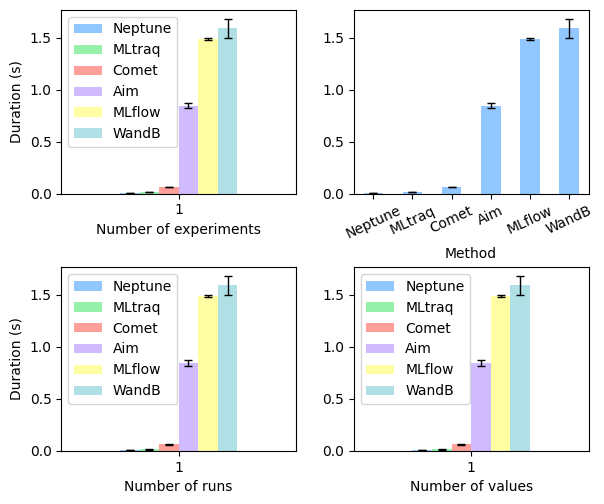


Averaged results by method



,duration,ratio_to_best
method,,
Neptune,0.004330,1.000000
MLtraq,0.012353,2.853015
Comet,0.060684,14.015752
Aim,0.844539,195.057186
MLflow,1.487704,343.604453
WandB,1.591970,367.686075


In [49]:
e = session.create_experiment("exp-1", if_exists="replace")
e.add_runs(
    method=["Aim", "Comet", "WandB", "Neptune", "MLtraq", "MLflow"],
    i=range(10),
    n_experiments=[1],
    n_runs=[1],
    n_values=[1],
)

# Parallelization disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

The analysis of the test procedures with `pyinstrument` reveals where most of the time is spent for each method:

* WandB and MLflow are the worst performing, with time domainated by threading and events management.
* Aim follows, spending most of the time to create and manage the database.
* Comet is next, with threading management taking most of the time.
* MLtraq spends most of the time writing to SQLite, with no threading.
* Comet is the best performing, with no threading, no SQLite database, simply writing the tracking data to disk.

In summary, the least you do to start up, the faster you are. Threading and communication are expensive, as well as database management.

### Experiment 2: How much time to track 1K values?

  2%|1         | 1/60 [00:01<01:05,  1.10s/it]

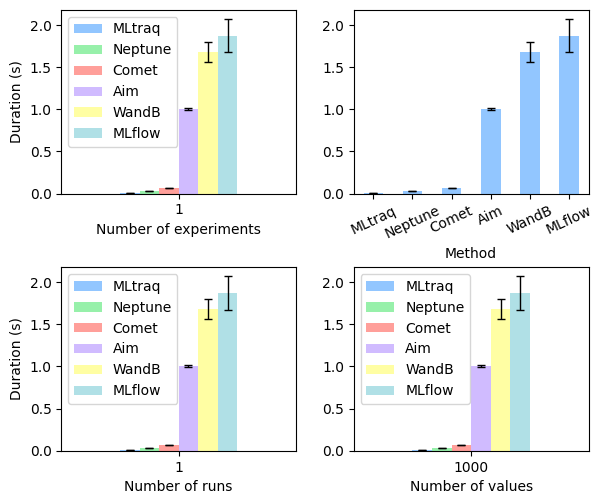


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.011145,1.000000
Neptune,0.031370,2.814807
Comet,0.069188,6.208217
Aim,1.003334,90.028722
WandB,1.679961,150.742135
MLflow,1.876232,168.353481


In [76]:
e = session.create_experiment("exp-2")
e.add_runs(
    method=["Aim", "Comet", "WandB", "Neptune", "MLtraq", "MLflow"],
    i=range(10),
    n_experiments=[1],
    n_runs=[1],
    n_values=[10**3],
)

# Parallelization disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

* Performance changes drammatically, with WandB, MLflow and Aim being the worst performing, either due to thread communication (WandB, Aim) or database management (MLflow).
* Comet is next, followed by Neptune and MLtraq.

The advantage of MLtraq is in how the data is tracked and stored. Being very close to simply add an element to an array and serializing it to an SQLite column value with the amazingly fast DATAPAK serialization strategy, it is hard to beat.

### Experiment 3: How much time to track 10 runs?

 17%|#6        | 1/6 [00:14<01:10, 14.10s/it]

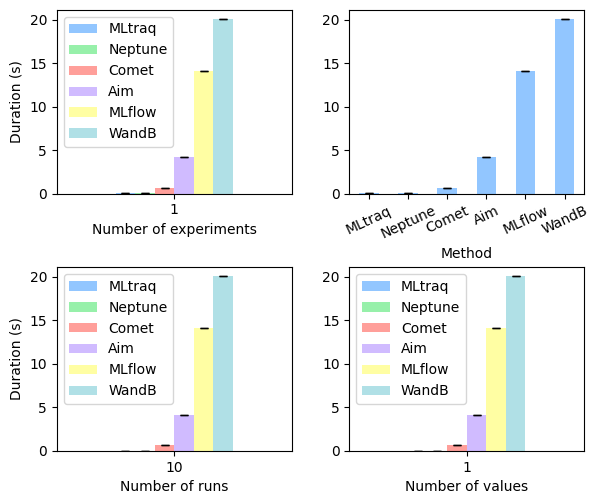


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.017879,1.000000
Neptune,0.021273,1.189832
Comet,0.631313,35.310308
Aim,4.161030,232.732815
MLflow,14.089638,788.055148
WandB,20.096175,1124.010012


In [62]:
e = session.create_experiment("exp-3")
e.add_runs(
    method=["Aim", "Comet", "WandB", "Neptune", "MLtraq", "MLflow"],
    i=range(1),
    n_experiments=[1],
    n_runs=[10],
    n_values=[1],
)

# Parallelization disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

The results are very similar to Experiment 1, with MLtraq being now the top performing.

* Neptune and Comet use the filesystem as database and MLtraq uses SQLite. As the number of files written by Neptune/Comet increases, it becomes more expensive than writing efficiently to a single database file. Writing to a single SQLite file can be 35% faster than writing to many filesystem files, see https://www.sqlite.org/fasterthanfs.html for more details.

* Comet creates a ZIP of the files to be uploaded to their cloud, which results in an additional time penalty.



### Experiment 4: How much time to track 100 runs?

 33%|###3      | 1/3 [00:06<00:13,  6.69s/it]

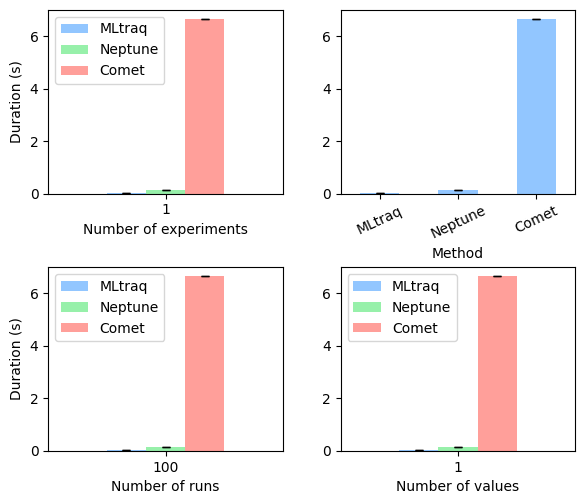


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.010054,1.000000
Neptune,0.134802,13.407798
Comet,6.657113,662.135767


In [72]:
e = session.create_experiment("exp-4")
e.add_runs(
    method=["Comet", "Neptune", "MLtraq"],
    i=range(1),
    n_experiments=[1],
    n_runs=[100],
    n_values=[1],
)

# Parallelization disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

Results are very similar to Experiment 4. Creating a ZIP of the logs is very expensive for Comet. The other methods have been excluded as they are orders of magnitude slower.

### Experiment 5: How much time to track 1K runs and 1K values?

 12%|#2        | 1/8 [00:00<00:01,  4.11it/s]

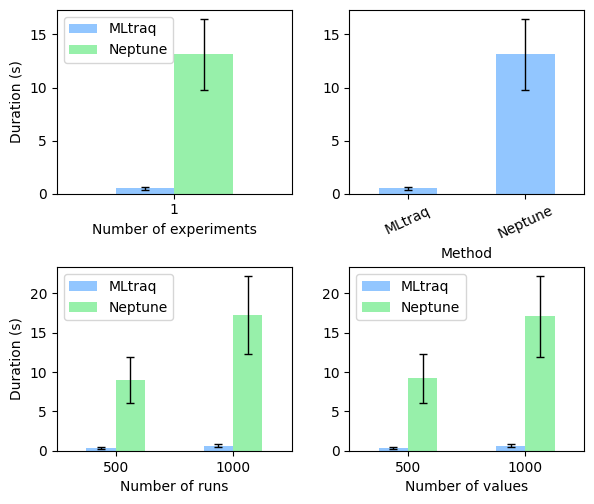


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.482624,1.000000
Neptune,13.136492,27.218909


In [78]:
e = session.create_experiment("exp-5")
e.add_runs(
    method=["Neptune", "MLtraq"],
    i=range(1),
    n_experiments=[1],
    n_runs=[500, 1000],
    n_values=[500, 1000],
)

# Parallelization disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

* As we increase the number of tracked values or runs, MLtraq becomes more and more competitive. With no threading and no filesystem bottleneck, it is by far the fastest method on realistic workloads.
* With up to 1K runs and values, MLtraq is 25x faster than Neptune on average.
The other methods WandB, Aim, Comet and MLflow are orders of magnitude slower.

## Conclusion

The design choices on threading and database management are the most impactful in terms of time performance and robustness. E.g., too many open files and IPC errors. Is it worth it?

* Trading time performance to be able to stream the tracked data efficiently via threading is a sensible decision. Without threading, you end up blocking the experiment to write/send the tracking data over the network, resulting in (expensive) experiment delays. Being able to inspect the progress of experiments during their execution is valuable and depends on this capability.
* Using the filesystem as a database comes at a high performance/stability cost, with no apparent benefit for the users.

### Which method is faster?

MLtraq can be 100x faster than other experiment trackers on realistic workloads with hundreds of thousands of runs and tracked values. In the experiments, MLtraq is consistently the best performing.

### Which method should you use?

It is not always about being faster. Having a monitoring dashboard to assess the progress of experiments could be useful, and you must weight costs and benefits. Robustness of tracking is even more important. Relying on closed commercial systems is always a risk to manage.

But, if you just want to track fast, MLtraq might be the right solution for you.
